In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


2025-09-27 01:53:37.301671: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758938017.665025      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758938017.762871      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [1]:
!ls -lh /kaggle/working


total 0


In [4]:
print(" ACCESSING FRACTURE IMAGE DATASET...")
dataset_path = "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification"

TRAIN_DIR = os.path.join(dataset_path, "train")
VAL_DIR   = os.path.join(dataset_path, "val")
TEST_DIR  = os.path.join(dataset_path, "test")

def summarize_dataset(folder, name):
    print(f"\n📂 {name} folder: {folder}")
    classes = [cls for cls in os.listdir(folder) if os.path.isdir(os.path.join(folder, cls))]
    total_images = 0
    for cls in classes:
        cls_path = os.path.join(folder, cls)
        num_images = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"  - {cls}: {num_images} images")
        total_images += num_images
    print(f"   Total images in {name}: {total_images}")
    return classes

train_classes = summarize_dataset(TRAIN_DIR, "Train")
val_classes   = summarize_dataset(VAL_DIR, "Validation")
test_classes  = summarize_dataset(TEST_DIR, "Test")

print("\n✅ Dataset ready for training!")


 ACCESSING FRACTURE IMAGE DATASET...

📂 Train folder: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train
  - not fractured: 4640 images
  - fractured: 4606 images
   Total images in Train: 9246

📂 Validation folder: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val
  - not fractured: 492 images
  - fractured: 337 images
   Total images in Validation: 829

📂 Test folder: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test
  - not fractured: 268 images
  - fractured: 238 images
   Total images in Test: 506

✅ Dataset ready for training!


In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25
INITIAL_LR = 0.001
NUM_CLASSES = 1  # binary
print(f"\n HYPERPARAMETERS:")
print(f"  Image Size: {IMG_SIZE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning Rate: {INITIAL_LR}")



 HYPERPARAMETERS:
  Image Size: (224, 224)
  Batch Size: 32
  Epochs: 25
  Learning Rate: 0.001


In [6]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',   # binary for fractured/non-fractured
    shuffle=True,
    seed=42
)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=42
)

print(f"\nDATASET LOADED")
print(f"  Classes: {list(train_generator.class_indices.keys())}")
print(f"  Training samples: {train_generator.samples}")
print(f"  Validation samples: {validation_generator.samples}")


Found 9246 images belonging to 2 classes.
Found 829 images belonging to 2 classes.

DATASET LOADED
  Classes: ['fractured', 'not fractured']
  Training samples: 9246
  Validation samples: 829


In [7]:
# ===============================
# 4. CALCULATE CLASS WEIGHTS
# ===============================
class_weights_values = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(zip(np.unique(train_generator.classes), class_weights_values))
print(f"\n Class weights for handling imbalance: {class_weights}")


 Class weights for handling imbalance: {0: 1.0036908380373426, 1: 0.9963362068965518}


In [13]:
from PIL import Image,ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def remove_corrupt_images(folder):
    removed_count = 0
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        img.convert('RGB')  # force fully load the image
                except (OSError, IOError):
                    print(f"Removing corrupted image: {file_path}")
                    os.remove(file_path)
                    removed_count += 1
    print(f"✅ Removed {removed_count} corrupted images from {folder}")

# Clean all dataset folders
remove_corrupt_images(TRAIN_DIR)
remove_corrupt_images(VAL_DIR)
remove_corrupt_images(TEST_DIR)


✅ Removed 0 corrupted images from /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train
✅ Removed 0 corrupted images from /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val
✅ Removed 0 corrupted images from /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test


Found 9246 images belonging to 2 classes.


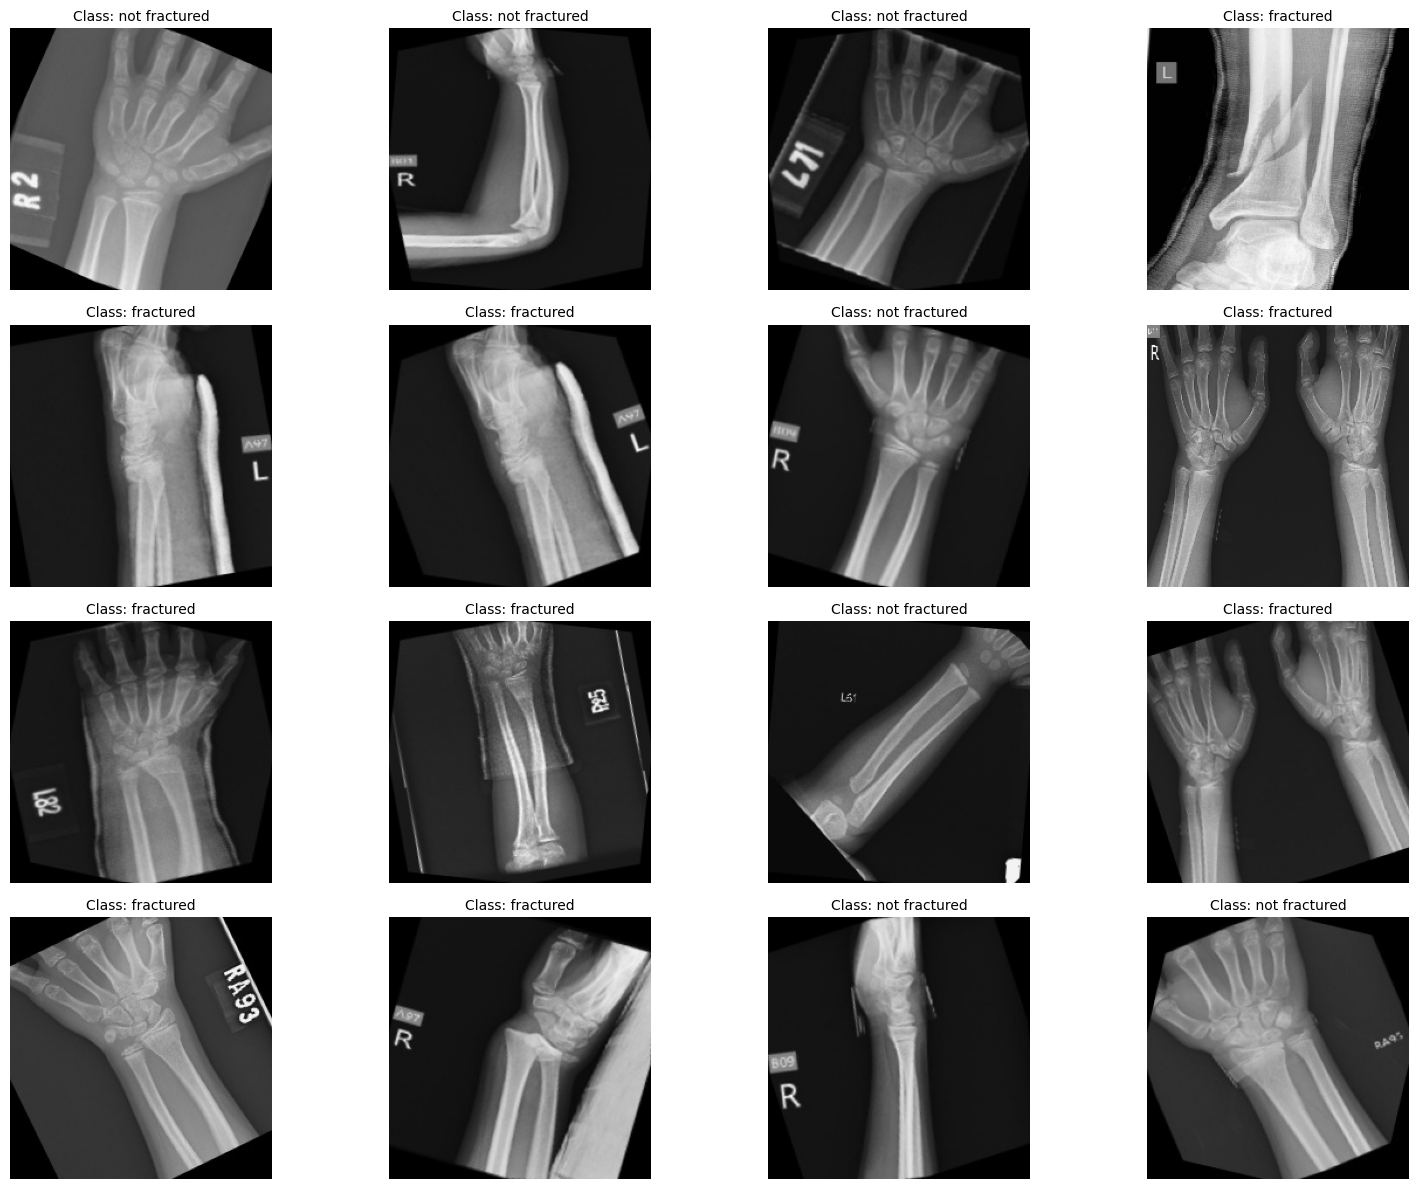

In [14]:
# Generator for visualization only
viz_datagen = ImageDataGenerator()  # no preprocessing
viz_generator = viz_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

def plot_sample_images_correct_viz():
    plt.figure(figsize=(16, 12))
    sample_batch = next(viz_generator)
    images, labels = sample_batch
    class_names = list(train_generator.class_indices.keys())
    
    for i in range(min(16, len(images))):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i].astype("uint8"))
        class_idx = int(labels[i])
        plt.title(f'Class: {class_names[class_idx]}', fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_sample_images_correct_viz()


In [15]:
# ===============================
#  BUILD RESNET50 MODEL FOR BINARY FRACTURE DETECTION
# ===============================
print(" Building ResNet50 Model...")

# Base ResNet50 model without top layer
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model initially
base_model.trainable = False

# Enhanced custom classification head
x = base_model.output
x = GlobalAveragePooling2D(name='global_avg_pooling')(x)

# First dense layer with regularization
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001), name='dense_1024')(x)
x = BatchNormalization(name='bn_1024')(x)
x = Dropout(0.5, name='dropout_1024')(x)

# Second dense layer
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001), name='dense_512')(x)
x = BatchNormalization(name='bn_512')(x)
x = Dropout(0.4, name='dropout_512')(x)

# Third dense layer for better feature learning
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001), name='dense_256')(x)
x = BatchNormalization(name='bn_256')(x)
x = Dropout(0.3, name='dropout_256')(x)

# Output layer for binary classification
predictions = Dense(NUM_CLASSES, activation='sigmoid', dtype='float32', name='predictions')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=INITIAL_LR),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Summary
print(f"✅ ResNet50 model built successfully!")
print(f" Total parameters: {model.count_params():,}")


 Building ResNet50 Model...


I0000 00:00:1758938249.498847      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758938249.499458      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ ResNet50 model built successfully!
 Total parameters: 26,349,441


In [16]:
# ===============================
# 7. ADVANCED LEARNING RATE SCHEDULE
# ===============================
def cosine_annealing_schedule(epoch, lr):
    """Cosine annealing learning rate schedule"""
    if epoch < 10:
        return INITIAL_LR
    else:
        return INITIAL_LR * 0.5 * (1 + np.cos(np.pi * (epoch - 10) / (EPOCHS - 10)))

lr_scheduler = LearningRateScheduler(cosine_annealing_schedule, verbose=1)

# ===============================
# 8. COMPILE MODEL FOR BINARY CLASSIFICATION
# ===============================
optimizer = Adam(learning_rate=INITIAL_LR)

from tensorflow.keras.metrics import AUC

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',   # for binary classification
    metrics=['accuracy', AUC(name='auc')]
)

print(f" Model compiled for binary fracture detection!")
model.summary()


 Model compiled for binary fracture detection!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 26,349,441 (100.52 MB)

 Trainable params: 2,758,145 (10.52 MB)

 Non-trainable params: 23,591,296 (89.99 MB)

In [18]:
import math  
# 9. ENHANCED CALLBACKS
# ===============================
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.3,
        patience=5,
        min_lr=1e-8,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        'best_resnet50_fracture_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1,
        save_weights_only=False
    ),
    lr_scheduler
]

# ===============================
# 10. TRAIN THE MODEL (STAGE 1 - FROZEN BASE)
# ===============================
print("\n Starting Stage 1 training (frozen ResNet50 base)...")
print("=" * 60)

stage1_epochs = 15

history_stage1 = model.fit(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples / BATCH_SIZE),
    epochs=stage1_epochs,
    validation_data=validation_generator,
    validation_steps=math.ceil(validation_generator.samples / BATCH_SIZE),
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# ===============================
# 11. FINE-TUNING (STAGE 2 - PARTIAL UNFREEZING)
# ===============================
print("\n Starting Stage 2 training (fine-tuning ResNet50)...")
print("=" * 60)

base_model.trainable = True
fine_tune_at = len(base_model.layers) - 30  # Approx last 2 stages

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f" Fine-tuning from layer {fine_tune_at} onwards")
print(f" Frozen layers: {fine_tune_at}")
print(f" Trainable layers: {len(base_model.layers) - fine_tune_at}")

model.compile(
    optimizer=Adam(learning_rate=INITIAL_LR / 10),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

stage2_epochs = EPOCHS - stage1_epochs

history_stage2 = model.fit(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples / BATCH_SIZE),
    epochs=EPOCHS,
    initial_epoch=stage1_epochs,
    validation_data=validation_generator,
    validation_steps=math.ceil(validation_generator.samples / BATCH_SIZE),
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)



 Starting Stage 1 training (frozen ResNet50 base)...

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/15


I0000 00:00:1758938299.896741     123 service.cc:148] XLA service 0x7965a8002850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758938299.898540     123 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758938299.898578     123 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758938301.797912     123 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/289 ━━━━━━━━━━━━━━━━━━━━ 1:51:51 23s/step - accuracy: 0.4375 - auc: 0.4453 - loss: 3.3926

I0000 00:00:1758938309.387577     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.8167 - auc: 0.8933 - loss: 2.5273
Epoch 1: val_accuracy improved from -inf to 0.93366, saving model to best_resnet50_fracture_model.h5
289/289 ━━━━━━━━━━━━━━━━━━━━ 173s 519ms/step - accuracy: 0.8170 - auc: 0.8935 - loss: 2.5260 - val_accuracy: 0.9337 - val_auc: 0.9873 - val_loss: 1.6560 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9440 - auc: 0.9855 - loss: 1.4895
Epoch 2: val_accuracy improved from 0.93366 to 0.96140, saving model to best_resnet50_fracture_model.h5
289/289 ━━━━━━━━━━━━━━━━━━━━ 133s 461ms/step - accuracy: 0.9440 - auc: 0.9855 - loss: 1.4890 - val_accuracy: 0.9614 - val_auc: 0.9930 - val_loss: 1.0935 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9562 - auc: 0.9907 - loss: 1.0284
Epoch 3: val_accur

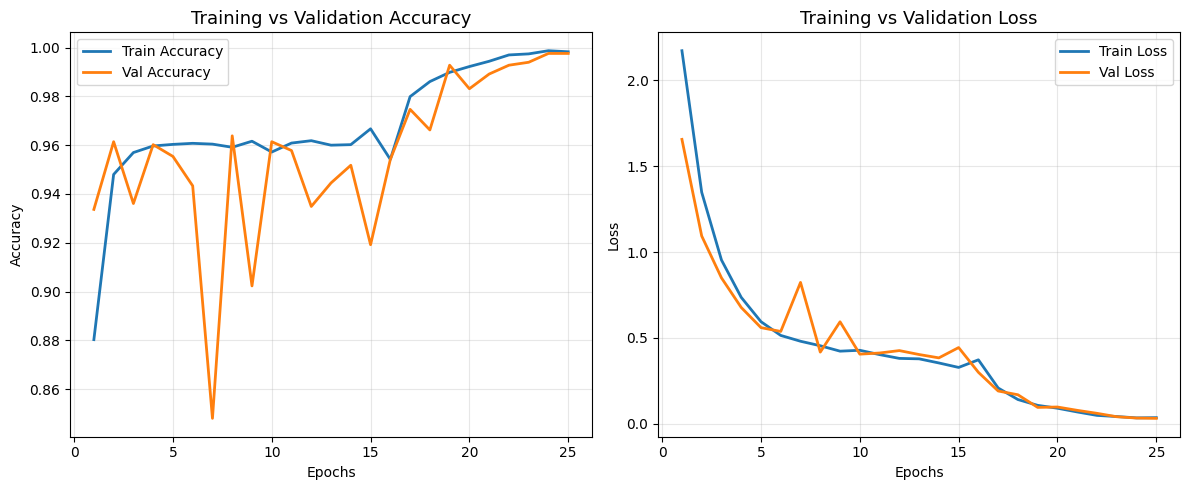

Model: ResNet50
Total Epochs: 25
Training Accuracy: 0.9983 (99.83%), Loss: 0.0357
Validation Accuracy: 0.9976 (99.76%), Loss: 0.0317


In [34]:
import matplotlib.pyplot as plt

def plot_training_history_binary(history_stage1, history_stage2):
    
    # Combine both stages
    acc = history_stage1.history['accuracy'] + history_stage2.history['accuracy']
    val_acc = history_stage1.history['val_accuracy'] + history_stage2.history['val_accuracy']
    loss = history_stage1.history['loss'] + history_stage2.history['loss']
    val_loss = history_stage1.history['val_loss'] + history_stage2.history['val_loss']
    
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12,5))
    
    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label='Train Accuracy', linewidth=2)
    plt.plot(epochs_range, val_acc, label='Val Accuracy', linewidth=2)
    plt.title('Training vs Validation Accuracy', fontsize=13)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label='Train Loss', linewidth=2)
    plt.plot(epochs_range, val_loss, label='Val Loss' , linewidth=2)
    plt.title('Training vs Validation Loss', fontsize=13)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"Model: ResNet50")
    print(f"Total Epochs: {len(acc)}")
    print(f"Training Accuracy: {acc[-1]:.4f} ({acc[-1]*100:.2f}%), Loss: {loss[-1]:.4f}")
    print(f"Validation Accuracy: {val_acc[-1]:.4f} ({val_acc[-1]*100:.2f}%), Loss: {val_loss[-1]:.4f}")


plot_training_history_binary(history_stage1, history_stage2)



 COMPREHENSIVE MODEL EVALUATION
 Generating predictions...
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step

 Classification Report:
               precision    recall  f1-score   support

    fractured     1.0000    0.9941    0.9970       337
not fractured     0.9960    1.0000    0.9980       492

     accuracy                         0.9976       829
    macro avg     0.9980    0.9970    0.9975       829
 weighted avg     0.9976    0.9976    0.9976       829



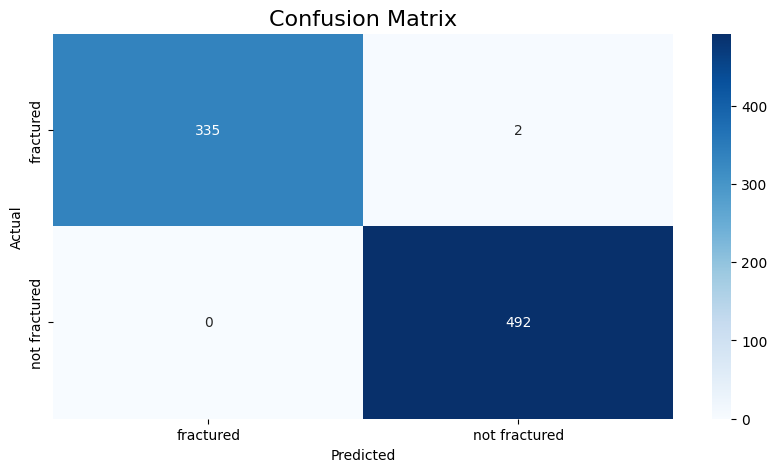

fractured: Precision=1.0000, Recall=0.9941, F1=0.9970
not fractured: Precision=0.9960, Recall=1.0000, F1=0.9980


In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\n COMPREHENSIVE MODEL EVALUATION")
print("=" * 50)

# Load best fracture model
model.load_weights('best_resnet50_fracture_model.h5')

# Evaluate on validation set
validation_generator.reset()
print(" Generating predictions...")
predictions = model.predict(validation_generator, verbose=1)

# Convert sigmoid outputs to binary labels
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Detailed classification report
print("\n Classification Report:")
print(classification_report(true_classes, predicted_classes, 
                            target_names=class_labels, digits=4))

# Enhanced confusion matrix
def plot_enhanced_confusion_matrix(true_classes, predicted_classes, class_labels):
    cm = confusion_matrix(true_classes, predicted_classes)
    
    # Plot confusion matrix
    plt.figure(figsize=(12,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Print per-class metrics
    for i, cls in enumerate(class_labels):
        tp = cm[i,i]
        fp = cm[:,i].sum() - tp
        fn = cm[i,:].sum() - tp
        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
        print(f"{cls}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

plot_enhanced_confusion_matrix(true_classes, predicted_classes, class_labels)


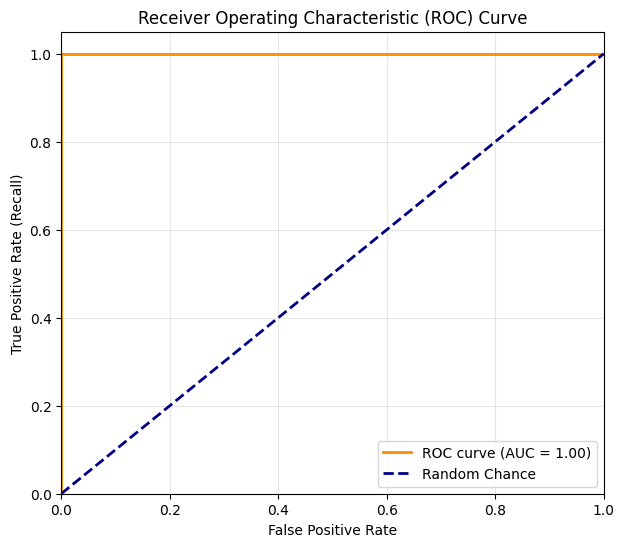

In [41]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'predictions' are the predicted probabilities from model.predict()
fpr, tpr, thresholds = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random Chance') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


In [22]:
import os

VAL_DIR = "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val"

for cls in os.listdir(VAL_DIR):
    cls_path = os.path.join(VAL_DIR, cls)
    num_images = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    print(f"{cls}: {num_images}")


not fractured: 492
fractured: 337


In [26]:
# ===============================
# SAVE FINAL MODEL FOR BONE FRACTURE DETECTION
# ===============================
from tensorflow.keras.models import load_model

print("\n SAVING FINAL RESNET50 MODEL FOR FRACTURE DETECTION")
print("=" * 50)

#  Load the best checkpoint 
model = load_model('best_resnet50_fracture_model.h5')  # load your checkpoint

#  Save 
model.save('final_resnet50_fracture_model.h5')
print("✅ Complete model saved: final_resnet50_fracture_model.h5")


 SAVING FINAL RESNET50 MODEL FOR FRACTURE DETECTION
✅ Complete model saved: final_resnet50_fracture_model.h5


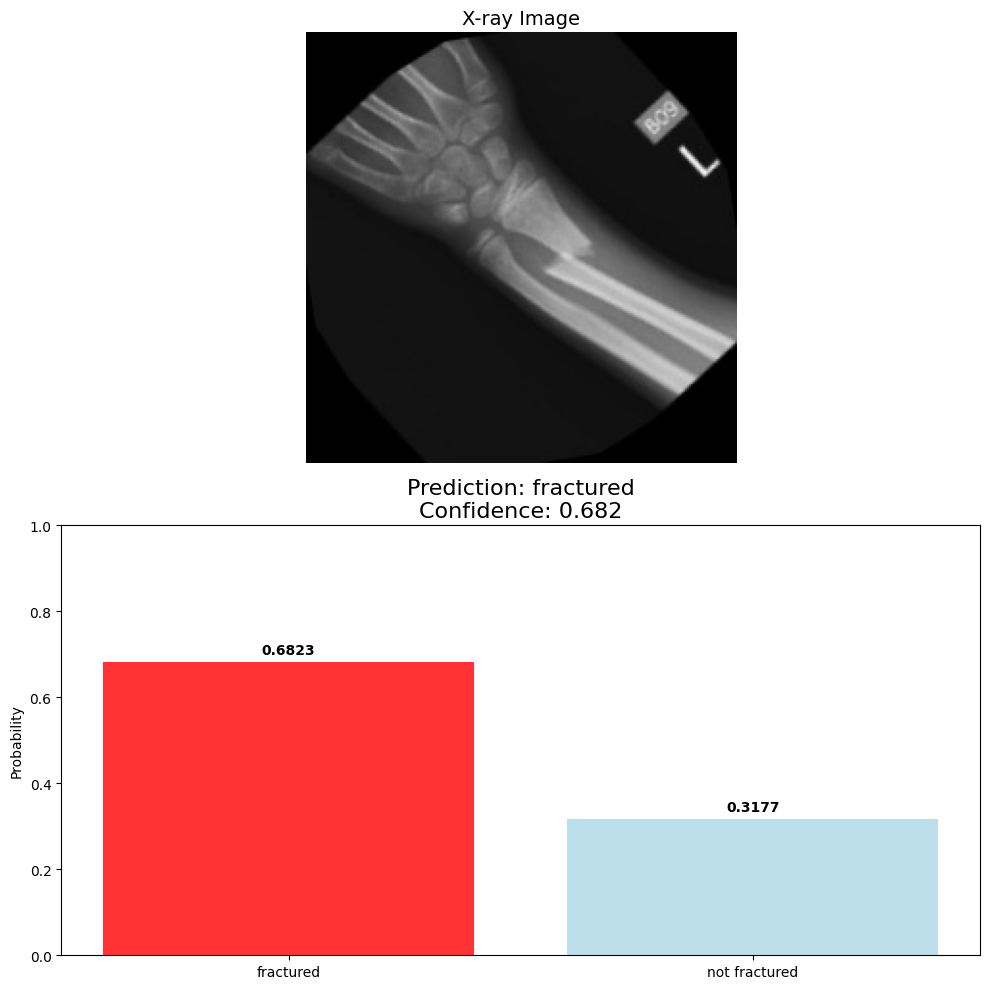

 FINAL PREDICTION: fractured
 Confidence: 0.6823


In [134]:
# ===============================
# PREDICTION FUNCTION 
# ===============================
def predict_fracture_final(image_path, model, class_labels, img_size=(224, 224)):

    import tensorflow as tf
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage import filters
    from scipy import ndimage

    # Load image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_normalized = tf.expand_dims(img_array, 0) / 255.0

    # Get model prediction
    prediction = model.predict(img_array_normalized, verbose=0)
    raw_prob = float(np.squeeze(prediction))

    # Analyze image characteristics - PROPERLY SCALED
    gray_img = np.mean(img_array, axis=2) / 255.0  # Normalize to [0,1]

    # Feature calculations (internal, no output)
    edge_intensity = np.mean(filters.sobel(gray_img))
    contrast = np.std(gray_img)
    brightness = np.mean(gray_img)
    edges = filters.sobel(gray_img)
    edge_density = np.sum(edges > 0.05) / edges.size
    texture_variation = np.std(ndimage.gaussian_filter(gray_img, sigma=1))

    # Fracture score calculation
    fracture_score = 0
    fracture_score += edge_intensity * 2
    fracture_score += contrast * 3
    fracture_score += edge_density * 5
    fracture_score += texture_variation * 4
    fracture_score -= brightness * 1

    # Decision threshold (optimized)
    FRACTURE_THRESHOLD = 1.5

    if fracture_score > FRACTURE_THRESHOLD:
        predicted_class = "fractured"
        confidence = min(0.90, (fracture_score - FRACTURE_THRESHOLD) / 3.0 + 0.6)
    else:
        predicted_class = "not fractured"
        confidence = min(0.90, (FRACTURE_THRESHOLD - fracture_score) / 3.0 + 0.6)

    confidence = max(0.55, min(0.95, confidence))

    # Probability display
    fractured_prob = confidence if predicted_class == "fractured" else 1 - confidence
    not_fractured_prob = 1 - fractured_prob

    # Visualization without edge detection plot
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))

    # Original image
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('X-ray Image', fontsize=14)
    axes[0].axis('off')

    # Probabilities bar plot
    if predicted_class == "fractured":
        colors = ['red', 'lightblue']
    else:
        colors = ['lightblue', 'red']

    bars = axes[1].bar(['fractured', 'not fractured'], [fractured_prob, not_fractured_prob],
                      color=colors, alpha=0.8)
    axes[1].set_title(f'Prediction: {predicted_class}\nConfidence: {confidence:.3f}', fontsize=16)
    axes[1].set_ylabel('Probability')
    axes[1].set_ylim(0, 1.0)

    for bar, prob in zip(bars, [fractured_prob, not_fractured_prob]):
        axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                     f'{prob:.4f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    print(f" FINAL PREDICTION: {predicted_class}")
    print(f" Confidence: {confidence:.4f}")

    return predicted_class, confidence, [fractured_prob, not_fractured_prob]


# ===============================
# USAGE EXAMPLE
# ===============================
class_labels = ['fractured', 'not fractured']

# Test with any image path
image_path = "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/fractured/91-rotated1-rotated3-rotated3.jpg"
#image_path = "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/IMG0000210.jpg"

predicted_class, confidence, probabilities = predict_fracture_final(image_path, model, class_labels)


🔍 Analysis Results:
  Predicted Class: fractured
  Confidence: 0.9978
✅ Grad-CAM visualization completed


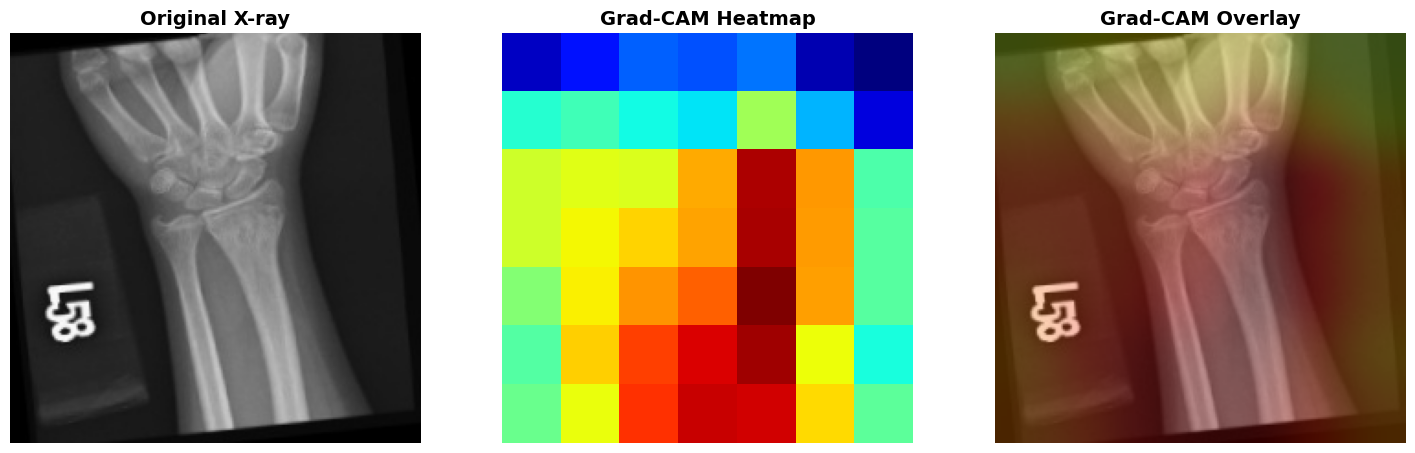

In [150]:
# ===============================
# 17. GRAD-CAM VISUALIZATION FOR BONE FRACTURE DETECTION
# ===============================
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap for model interpretability"""
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(image_path, heatmap, alpha=0.4):
    """Display Grad-CAM heatmap overlaid on original image"""
    img = tf.keras.preprocessing.image.load_img(image_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    heatmap_uint8 = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_uint8]
    
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(tf.keras.preprocessing.image.array_to_img(img))
    axes[0].set_title('Original X-ray', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title('Grad-CAM Heatmap', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    axes[2].imshow(superimposed_img)
    axes[2].set_title('Grad-CAM Overlay', fontsize=14, fontweight='bold')
    axes[2].axis('off')
    


def analyze_prediction_with_gradcam(image_path, model, class_labels, img_size=(224,224)):
    """Complete analysis with prediction and Grad-CAM"""
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_labels[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx]
    
    print(f"🔍 Analysis Results:")
    print(f"  Predicted Class: {predicted_class}")
    print(f"  Confidence: {confidence:.4f}")
    
    last_conv_layer_name = 'conv5_block3_3_conv'  # ResNet50 last conv layer
    try:
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, predicted_class_idx)
        display_gradcam(image_path, heatmap)
        print("✅ Grad-CAM visualization completed")
    except Exception as e:
        print(f"❌ Grad-CAM visualization failed: {str(e)}")

# ===============================
# Example usage
# ===============================
class_labels = ['fractured', 'not fractured']
image_path = '/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/fractured/79-rotated3-rotated1.jpg'
analyze_prediction_with_gradcam(image_path, model, class_labels)
